## LATIHAN ARIMA-TRANSFORMER

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm, shapiro, anderson
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest

In [2]:
import tensorflow as tf
import keras

print(tf.__version__, keras.__version__)

2.18.0 3.8.0


In [3]:
data_df = pd.read_excel('QBO Data.xlsx')
columns_name = ['25 hPa']
Data = pd.DataFrame(data_df, columns=columns_name)
time_series_numpy = Data.values.astype(float)  # Replace 'your_column_name' with the actual column name

# Seasonal features (assuming you have a time index)
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)

In [4]:
print(data_df.columns)

Index(['30 hPa', '25 hPa', '20 hPa'], dtype='object')


In [5]:
Data.tail()

,25 hPa
414,-297
415,-319
416,-332
417,-339
418,-320


In [6]:
def add_lag_features(data_df, lags):
    for lag in lags:
        column_name_lag = f'lag_{lag}'
        data_df[column_name_lag] = data_df['25 hPa'].shift(lag)

def add_rolling_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_min = f'rolling_min_{window_size}'
        column_name_max = f'rolling_max_{window_size}'
        column_name_ma = f'moving_average_{window_size}'
        column_name_ema = f'ema_{window_size}'
        column_name_std = f'moving_std_{window_size}'
        column_name_median = f'moving_median_{window_size}'

        data_df[column_name_min] = data_df['25 hPa'].rolling(window=window_size).min()
        data_df[column_name_max] = data_df['25 hPa'].rolling(window=window_size).max()
        data_df[column_name_ma] = data_df['25 hPa'].rolling(window=window_size).mean()
        data_df[column_name_ema] = data_df['25 hPa'].ewm(span=window_size, adjust=False).mean()
        data_df[column_name_std] = data_df['25 hPa'].rolling(window=window_size).std()
        data_df[column_name_median] = data_df['25 hPa'].rolling(window=window_size).median()

def add_interaction_features(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_interaction = f'interaction_ma_ema_{window_size}'
        data_df[column_name_interaction] = data_df[f'moving_average_{window_size}'] * data_df[f'ema_{window_size}']

def add_seasonal_features(data_df):
    data_df['quarter'] = data_df.index.quarter
    data_df['year'] = data_df.index.year

def add_rate_of_change(data_df, lags):
    for lag in lags:
        column_name_roc = f'roc_{lag}'
        data_df[column_name_roc] = (data_df['25 hPa'] - data_df['25 hPa'].shift(lag)) / data_df['25 hPa'].shift(lag)

def add_cumulative_sum(data_df):
    data_df['cumulative_sum'] = data_df['25 hPa'].cumsum()

def add_ewma_std(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_ewma_std = f'ewma_std_{window_size}'
        data_df[column_name_ewma_std] = data_df['25 hPa'].ewm(span=window_size, adjust=False).std()

def add_additional_statistics(data_df, window_sizes):
    for window_size in window_sizes:
        column_name_lagged_ma = f'lagged_ma_{window_size}'
        column_name_lagged_ema = f'lagged_ema_{window_size}'
        column_name_acf = f'autocorr_{window_size}'

        data_df[column_name_lagged_ma] = data_df[f'moving_average_{window_size}'].shift(1)
        data_df[column_name_lagged_ema] = data_df[f'ema_{window_size}'].shift(1)
        data_df[column_name_acf] = data_df['25 hPa'].autocorr(lag=window_size)

def add_z_scores(data_df):
    # Z-Score based on standard deviation
    data_df['z_score'] = (data_df['25 hPa'] - data_df['25 hPa'].mean()) / data_df['25 hPa'].std()

    # Z-Score based on median and median absolute deviation (MAD)
    median = data_df['25 hPa'].median()
    mad = np.median(np.abs(data_df['25 hPa'] - median))
    data_df['mad_z_score'] = (data_df['25 hPa'] - median) / mad

def add_log_returns(data_df):
    data_df['log_returns'] = np.log(data_df['25 hPa'] / data_df['25 hPa'].shift(1))


# List of lags for lag features
lags = [1, 2, 3]
# Lags represent the time intervals used to shift and create lag features, capturing historical values at different points in the past.

# List of window sizes for rolling statistics and other features
window_sizes = [2, 3, 12, 24, 28, 36]
# Window sizes determine the size of the rolling windows used for calculating statistics and features. Different sizes capture varying trends and patterns over specified periods.


add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

data_df_drop = data_df.dropna()

In [7]:
data_df_drop.head()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-10,-32,79,146,64.0,-147.0,-297.0,64.0,79.0,71.5,44.784972,...,0.297326,-161.178571,-204.733321,0.497812,-154.111111,-203.339901,-0.063237,0.806582,0.635359,0.210565
1990-03-10,109,177,181,79.0,64.0,-147.0,79.0,177.0,128.0,132.928324,...,0.297326,-162.928571,-185.165506,0.497812,-144.138889,-188.078285,-0.063237,1.311036,1.176796,0.806702
1990-04-10,124,152,166,177.0,79.0,64.0,152.0,177.0,164.5,145.642775,...,0.297326,-159.928571,-160.188575,0.497812,-130.638889,-168.344324,-0.063237,1.182349,1.038674,-0.152269
1990-05-10,124,160,136,152.0,177.0,79.0,152.0,160.0,156.0,155.214258,...,0.297326,-156.571429,-138.658328,0.497812,-118.000000,-151.028414,-0.063237,1.223529,1.082873,0.051293
1990-06-10,152,185,172,160.0,152.0,177.0,160.0,185.0,172.5,175.071419,...,0.297326,-153.000000,-118.061202,0.497812,-105.527778,-134.216068,-0.063237,1.352216,1.220994,0.145182


In [8]:
data_df_drop.tail()

,30 hPa,25 hPa,20 hPa,lag_1,lag_2,lag_3,rolling_min_2,rolling_max_2,moving_average_2,ema_2,...,autocorr_24,lagged_ma_28,lagged_ema_28,autocorr_28,lagged_ma_36,lagged_ema_36,autocorr_36,z_score,mad_z_score,log_returns
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-10,-238,-297,-316,-258.0,-167.0,-40.0,-297.0,-258.0,-277.5,-267.733977,...,0.297326,38.000000,1.511001,0.497812,37.638889,-0.392901,-0.063237,-1.128871,-1.441989,0.140773
2021-08-10,-233,-319,-330,-297.0,-258.0,-167.0,-319.0,-297.0,-308.0,-301.911326,...,0.297326,21.357143,-19.075964,0.497812,39.055556,-16.425717,-0.063237,-1.242116,-1.563536,0.071459
2021-09-10,-268,-332,-359,-319.0,-297.0,-258.0,-332.0,-319.0,-325.5,-321.970442,...,0.297326,4.500000,-39.760381,0.497812,33.222222,-32.781083,-0.063237,-1.309033,-1.635359,0.039944
2021-10-01,-283,-339,-368,-332.0,-319.0,-297.0,-339.0,-332.0,-335.5,-333.323481,...,0.297326,-13.285714,-59.914837,0.497812,22.694444,-48.955079,-0.063237,-1.345066,-1.674033,0.020865
2021-01-11,-279,-320,-351,-339.0,-332.0,-319.0,-339.0,-320.0,-329.5,-324.441160,...,0.297326,-29.785714,-79.162090,0.497812,10.027778,-64.633183,-0.063237,-1.247264,-1.569061,-0.057679


In [9]:
# Convert DataFrame to NumPy array
features_array = data_df_drop.to_numpy()

# Create input and output dataframes
input_data = pd.DataFrame(data_df_drop, columns=data_df.columns)
input_data1 = input_data.iloc[:-1, :]
output_data = input_data.iloc[1:, 0]

# Convert to NumPy arrays
features = input_data1.to_numpy()
target = output_data.to_numpy()

# Standardize features
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

# Standardize target variable
target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))

In [10]:
def feature_metrics(features, target):
    # 1. F-statistic (ANOVA)
    f_stat, p_values_anova = f_regression(features, target)

    # 2. Random Forest Feature Importance
    rf_model = RandomForestRegressor()
    rf_model.fit(features, target)
    rf_feature_importances = rf_model.feature_importances_

    # 3. Mutual Information
    mutual_info_scores = mutual_info_regression(features, target)

    # 4. Principal Component Analysis (PCA)
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Return the selected features based on each method
    selected_features = {
        'f_stat': f_stat,
        'rf_feature_importances': rf_feature_importances,
        'mutual_info_scores': mutual_info_scores,
        'explained_variance_ratio': explained_variance_ratio,
        }

    return selected_features

In [11]:
def rank_and_top_features(scores, top_n=10):
    # Create a new dataframe for ranks
    ranks_df = pd.DataFrame()

    # Assign the ranking for each method
    for col in scores.columns:
        ranks_df[col+'_rank'] = scores[col].rank(ascending=False)

    # Calculate mean rank for each feature
    ranks_df['mean_rank'] = ranks_df.mean(axis=1)

    # Identify the top features based on mean rank
    top_features_index = ranks_df.nsmallest(top_n, 'mean_rank').index

    return ranks_df, top_features_index


Top 20 Features Index:
Index(['25 hPa', '30 hPa', 'ema_2', 'rolling_max_2', '20 hPa', 'ema_3',
       'rolling_min_2', 'moving_median_2', 'moving_average_3', 'mad_z_score',
       'z_score', 'interaction_ma_ema_2', 'rolling_min_3', 'moving_average_2',
       'lag_1', 'ema_12', 'lag_2', 'rolling_max_3', 'rolling_max_12',
       'moving_median_12'],
      dtype='object')


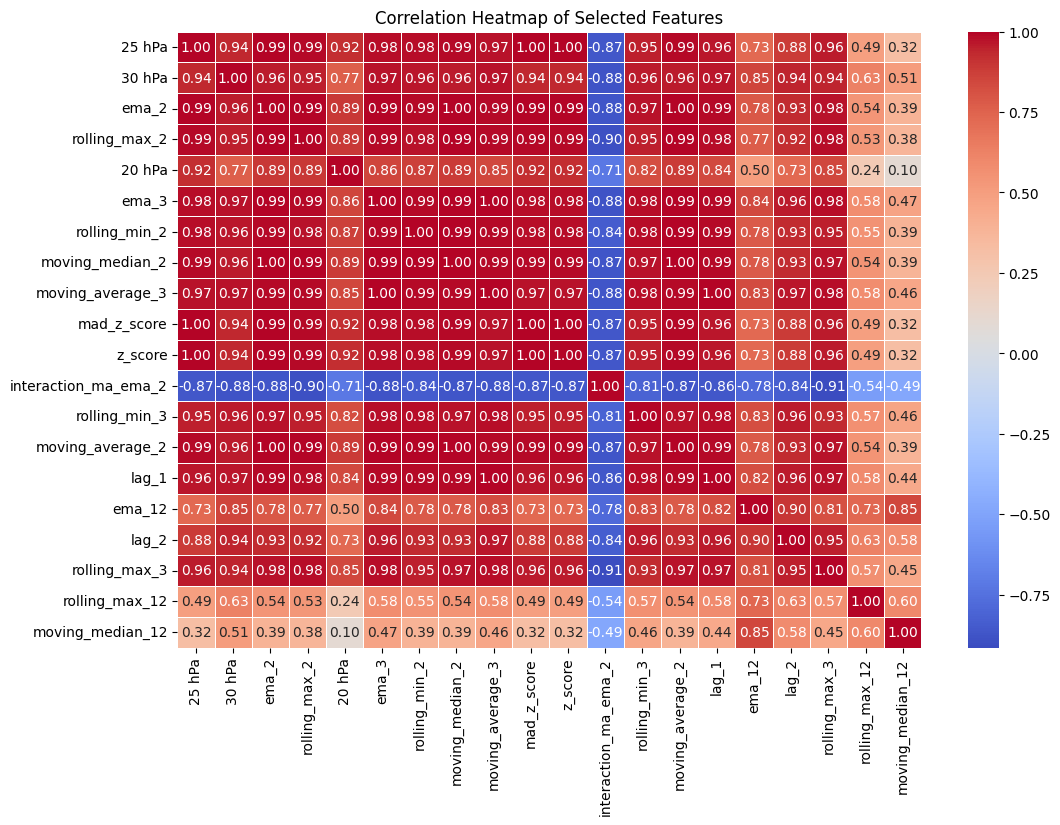

In [12]:
# Calculate and rank features
scores = feature_metrics(features_scaled, scaled_target)
df_scores = pd.DataFrame(scores)
top_n = 20  # Change this to the desired value

# Get ranked scores and top features index
df_scores_ranked, top_features_index = rank_and_top_features(df_scores, top_n=top_n)

# Assuming the features are stored in a DataFrame named 'data_df_drop' with 'Time' as the index
top_features_index_names = data_df_drop.columns[top_features_index]

print(f"\nTop {top_n} Features Index:")
print(top_features_index_names)

# Extract the top features from the original DataFrame
selected_features_df = data_df_drop[top_features_index_names]

correlation_matrix = selected_features_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

extracted_features_data = selected_features_df.to_numpy()

In [13]:
def prepare_time_series_data(data, time_steps=28, test_size=0.3, random_state=42):
    """
    Prepare time series data for training and testing.

    Parameters:
    - data: The time series data.
    - time_steps: Number of time steps to consider for each sample.
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed used by the random number generator.

    Returns:
    - x_train, x_test, y_train, y_test: Prepared training and testing sets.
    """
    data_scaler = StandardScaler()
    data_scaled = data_scaler.fit_transform(data)

    total_samples, num_features = data_scaled.shape
    n_steps = time_steps

    X = []
    y = []

    for i in range(n_steps, len(data_scaled)):
        X.append(data_scaled[i - n_steps:i, :])
        y.append(data_scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    return X, y, x_train, x_test, y_train, y_test

# Example usage:
time_steps = 28
X, y, x_train, x_test, y_train, y_test = prepare_time_series_data(extracted_features_data, time_steps)

print("Training set shapes:")
print(x_train.shape, y_train.shape)

print("\nTesting set shapes:")
print(x_test.shape, y_test.shape)

Training set shapes:
(227, 28, 20) (227,)

Testing set shapes:
(98, 28, 20) (98,)


In [14]:
# Assuming x_train, x_test, y_train, y_test are already prepared
# Using the same shapes you provided (2 time steps, 20 features)

import tensorflow.keras.backend as K

# Define the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(Dense(units=25, activation='relu'))  # Output layer with 1 neuron for regression tasks
model_lstm.add(Dense(units=1))  # Output layer with 1 neuron for regression tasks

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model_lstm.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath1 = 'best_model_lstm.h5'
model_checkpoint1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Train the model
history = model_lstm.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint1]
)

Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - loss: 0.9565 - mae: 0.9187 - r_squared: -65.8262
Epoch 1: val_loss improved from inf to 0.80265, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - loss: 0.9360 - mae: 0.9101 - r_squared: -60.5499 - val_loss: 0.8026 - val_mae: 0.8393 - val_r_squared: -39.2339
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.7137 - mae: 0.7864 - r_squared: -70.4288
Epoch 2: val_loss improved from 0.80265 to 0.63872, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.7165 - mae: 0.7813 - r_squared: -65.0240 - val_loss: 0.6387 - val_mae: 0.7278 - val_r_squared: -42.2979
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.6127 - mae: 0.7018 - r_squared: -74.2105
Epoch 3: val_loss improved from 0.63872 to 0.48495, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.5702 - mae: 0.6744 - r_squared: -69.2279 - val_loss: 0.4850 - val_mae: 0.6048 - val_r_squared: -46.1445
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4329 - mae: 0.5785 - r_squared: -81.5123
Epoch 4: val_loss improved from 0.48495 to 0.32300, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.4218 - mae: 0.5627 - r_squared: -75.0251 - val_loss: 0.3230 - val_mae: 0.4652 - val_r_squared: -51.0283
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3111 - mae: 0.4627 - r_squared: -92.1872
Epoch 5: val_loss improved from 0.32300 to 0.19661, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2959 - mae: 0.4454 - r_squared: -84.8193 - val_loss: 0.1966 - val_mae: 0.3415 - val_r_squared: -59.5480
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2907 - mae: 0.4071 - r_squared: -104.2689
Epoch 6: val_loss improved from 0.19661 to 0.15458, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2484 - mae: 0.3729 - r_squared: -97.3060 - val_loss: 0.1546 - val_mae: 0.3108 - val_r_squared: -70.0300
Epoch 7/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1870 - mae: 0.3086 - r_squared: -126.8498
Epoch 7: val_loss did not improve from 0.15458
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2233 - mae: 0.3494 - r_squared: -115.0058 - val_loss: 0.1743 - val_mae: 0.3298 - val_r_squared: -75.8558
Epoch 8/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2404 - mae: 0.3680 - r_squared: -142.1504
Epoch 8: val_loss improved from 0.15458 to 0.15330, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2178 - mae: 0.3514 - r_squared: -122.4044 - val_loss: 0.1533 - val_mae: 0.2906 - val_r_squared: -70.9051
Epoch 9/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1773 - mae: 0.3176 - r_squared: -123.2201
Epoch 9: val_loss improved from 0.15330 to 0.14626, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.1706 - mae: 0.3021 - r_squared: -113.0560 - val_loss: 0.1463 - val_mae: 0.2675 - val_r_squared: -65.6443
Epoch 10/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1736 - mae: 0.2843 - r_squared: -116.5252
Epoch 10: val_loss did not improve from 0.14626
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1560 - mae: 0.2763 - r_squared: -105.6482 - val_loss: 0.1587 - val_mae: 0.2757 - val_r_squared: -62.7271
Epoch 11/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1575 - mae: 0.2856 - r_squared: -109.8685
Epoch 11: val_loss did not improve from 0.14626
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1499 - mae: 0.2760 - r_squared: -100.9510 - val_loss: 0.1638 - val_mae: 0.2842 - val_r_squared: -61.3511
Epoch 12/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1903 - mae: 0.3133 - r_squared: -110.3482
Epoch 12: val_loss did not improve from 0.14626
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1551 - mae: 0.2854 - r_squared: -100.57

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.1201 - mae: 0.2565 - r_squared: -101.9767 - val_loss: 0.1320 - val_mae: 0.2511 - val_r_squared: -63.4724
Epoch 14/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1233 - mae: 0.2561 - r_squared: -115.2483
Epoch 14: val_loss improved from 0.13196 to 0.12755, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1228 - mae: 0.2575 - r_squared: -106.5557 - val_loss: 0.1276 - val_mae: 0.2459 - val_r_squared: -66.2027
Epoch 15/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1245 - mae: 0.2499 - r_squared: -126.9224
Epoch 15: val_loss improved from 0.12755 to 0.12561, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1168 - mae: 0.2448 - r_squared: -112.3434 - val_loss: 0.1256 - val_mae: 0.2449 - val_r_squared: -68.3460
Epoch 16/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0703 - mae: 0.1806 - r_squared: -121.8825
Epoch 16: val_loss improved from 0.12561 to 0.10448, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0969 - mae: 0.2164 - r_squared: -112.8338 - val_loss: 0.1045 - val_mae: 0.2250 - val_r_squared: -67.6938
Epoch 17/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0848 - mae: 0.1995 - r_squared: -119.7723
Epoch 17: val_loss improved from 0.10448 to 0.09103, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0948 - mae: 0.2175 - r_squared: -110.0489 - val_loss: 0.0910 - val_mae: 0.2098 - val_r_squared: -65.0557
Epoch 18/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1087 - mae: 0.2399 - r_squared: -119.9658
Epoch 18: val_loss did not improve from 0.09103
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0995 - mae: 0.2286 - r_squared: -107.7667 - val_loss: 0.1067 - val_mae: 0.2288 - val_r_squared: -64.1819
Epoch 19/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0781 - mae: 0.2095 - r_squared: -117.3583
Epoch 19: val_loss did not improve from 0.09103
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0938 - mae: 0.2200 - r_squared: -106.7147 - val_loss: 0.1032 - val_mae: 0.2242 - val_r_squared: -64.7447
Epoch 20/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1010 - mae: 0.2362 - r_squared: -116.4048
Epoch 20: val_loss improved from 0.09103 to 0.07995, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0930 - mae: 0.2172 - r_squared: -106.1834 - val_loss: 0.0799 - val_mae: 0.2013 - val_r_squared: -64.6366
Epoch 21/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0793 - mae: 0.2023 - r_squared: -119.2262
Epoch 21: val_loss did not improve from 0.07995
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0899 - mae: 0.2109 - r_squared: -107.4500 - val_loss: 0.0902 - val_mae: 0.2098 - val_r_squared: -67.6394
Epoch 22/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0893 - mae: 0.2203 - r_squared: -122.7531
Epoch 22: val_loss did not improve from 0.07995
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0903 - mae: 0.2065 - r_squared: -112.5343 - val_loss: 0.0912 - val_mae: 0.2119 - val_r_squared: -68.1825
Epoch 23/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0782 - mae: 0.1964 - r_squared: -127.1295
Epoch 23: val_loss improved from 0.07995 to 0.07382, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0827 - mae: 0.1970 - r_squared: -112.6310 - val_loss: 0.0738 - val_mae: 0.1931 - val_r_squared: -65.9971
Epoch 24/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0629 - mae: 0.1840 - r_squared: -122.2130
Epoch 24: val_loss did not improve from 0.07382
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0801 - mae: 0.1959 - r_squared: -110.4502 - val_loss: 0.1006 - val_mae: 0.2148 - val_r_squared: -67.3767
Epoch 25/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0841 - mae: 0.2097 - r_squared: -121.9518
Epoch 25: val_loss did not improve from 0.07382
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0827 - mae: 0.2007 - r_squared: -111.3833 - val_loss: 0.0785 - val_mae: 0.2029 - val_r_squared: -65.0781
Epoch 26/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0870 - mae: 0.1964 - r_squared: -117.1926
Epoch 26: val_loss did not improve from 0.07382
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0823 - mae: 0.1982 - r_squared: -108.53

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0766 - mae: 0.1954 - r_squared: -109.3549 - val_loss: 0.0640 - val_mae: 0.1802 - val_r_squared: -66.8405
Epoch 32/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0864 - mae: 0.1803 - r_squared: -124.3490
Epoch 32: val_loss did not improve from 0.06404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0782 - mae: 0.1800 - r_squared: -113.1287 - val_loss: 0.0719 - val_mae: 0.1798 - val_r_squared: -69.5140
Epoch 33/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0671 - mae: 0.1541 - r_squared: -126.9395
Epoch 33: val_loss improved from 0.06404 to 0.05967, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0682 - mae: 0.1626 - r_squared: -115.8084 - val_loss: 0.0597 - val_mae: 0.1754 - val_r_squared: -68.0667
Epoch 34/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1189 - mae: 0.2178 - r_squared: -123.0496
Epoch 34: val_loss did not improve from 0.05967
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0888 - mae: 0.1934 - r_squared: -112.1579 - val_loss: 0.0843 - val_mae: 0.2088 - val_r_squared: -66.9789
Epoch 35/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0761 - mae: 0.1918 - r_squared: -118.9957
Epoch 35: val_loss did not improve from 0.05967
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0770 - mae: 0.1949 - r_squared: -109.9869 - val_loss: 0.0680 - val_mae: 0.1838 - val_r_squared: -65.1356
Epoch 36/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0916 - mae: 0.1982 - r_squared: -117.3119
Epoch 36: val_loss did not improve from 0.05967
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0759 - mae: 0.1896 - r_squared: -107.43

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0704 - mae: 0.1901 - r_squared: -111.0473 - val_loss: 0.0565 - val_mae: 0.1758 - val_r_squared: -65.5778
Epoch 41/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0381 - mae: 0.1514 - r_squared: -120.0882
Epoch 41: val_loss did not improve from 0.05654
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0575 - mae: 0.1675 - r_squared: -110.0886 - val_loss: 0.0792 - val_mae: 0.1864 - val_r_squared: -68.6695
Epoch 42/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0824 - mae: 0.1885 - r_squared: -121.0663
Epoch 42: val_loss improved from 0.05654 to 0.05279, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0716 - mae: 0.1787 - r_squared: -112.7393 - val_loss: 0.0528 - val_mae: 0.1612 - val_r_squared: -66.1530
Epoch 43/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.0547 - mae: 0.1677 - r_squared: -119.6684
Epoch 43: val_loss did not improve from 0.05279
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0629 - mae: 0.1723 - r_squared: -108.9294 - val_loss: 0.0559 - val_mae: 0.1721 - val_r_squared: -66.0397
Epoch 44/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0591 - mae: 0.1712 - r_squared: -121.6014
Epoch 44: val_loss did not improve from 0.05279
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0626 - mae: 0.1760 - r_squared: -110.0948 - val_loss: 0.0794 - val_mae: 0.1976 - val_r_squared: -69.2337
Epoch 45/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0928 - mae: 0.2085 - r_squared: -123.4928
Epoch 45: val_loss improved from 0.05279 to 0.04965, saving model to best_model_lstm.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0721 - mae: 0.1844 - r_squared: -113.4026 - val_loss: 0.0496 - val_mae: 0.1630 - val_r_squared: -67.2414
Epoch 46/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0539 - mae: 0.1617 - r_squared: -123.2042
Epoch 46: val_loss did not improve from 0.04965
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0604 - mae: 0.1674 - r_squared: -112.2576 - val_loss: 0.0639 - val_mae: 0.1695 - val_r_squared: -70.5605
Epoch 47/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0363 - mae: 0.1328 - r_squared: -128.9296
Epoch 47: val_loss did not improve from 0.04965
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0529 - mae: 0.1484 - r_squared: -116.5306 - val_loss: 0.0633 - val_mae: 0.1742 - val_r_squared: -69.1258
Epoch 48/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0684 - mae: 0.1698 - r_squared: -128.9370
Epoch 48: val_loss did not improve from 0.04965
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0641 - mae: 0.1715 - r_squared: -113.59

In [15]:
def positional_embedding(inputs, name="positional_embedding"):
    # Get the length of the input sequence
    input_seq_len = inputs.shape[1]

    # Create positional embeddings using an Embedding layer
    # The output dimension is set to the last dimension of the input
    position_embed = layers.Embedding(input_dim=input_seq_len, output_dim=inputs.shape[-1], name=name)(tf.range(input_seq_len))

    # Add positional embeddings to the input
    return inputs + position_embed

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization for input sequence
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Multi-head self-attention mechanism
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Residual connection: add the original input to the output of attention mechanism
    res = x + inputs

    # Layer normalization for the residual connection
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward Part:
    # Convolutional layer with a ReLU activation function
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)

    # Apply dropout for regularization
    x = layers.Dropout(dropout)(x)

    # Convolutional layer with the same number of filters as the input dimension
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    # Add the output of the feed-forward part to the residual connection
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):

    # Define the input layer with the specified input shape
    inputs = keras.Input(shape = input_shape)

    # Add positional embedding to the input sequence
    x = positional_embedding(inputs)

    # Loop through the specified number of transformer blocks
    for _ in range(num_transformer_blocks):
        # Apply transformer_encoder function to the input sequence
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global Average Pooling to reduce spatial dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    # Loop through the specified MLP (Multi-Layer Perceptron) units
    for dim in mlp_units:
        # Fully connected layer with ReLU activation function
        x = layers.Dense(dim, activation="relu")(x)

        # Apply dropout for regularization
        x = layers.Dropout(mlp_dropout)(x)

    # Output layer with a single neuron (regression task)
    outputs = layers.Dense(1)(x)

    # Create a Keras Model with the defined input and output layers
    return keras.Model(inputs, outputs)

In [16]:
input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=16,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4,
#     mlp_units=[256],
#     mlp_dropout=0.2,
#     dropout=0.2,
# )


model = build_model(
    input_shape,
    head_size=16,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.2,
    dropout=0.2,
)

# Custom R-squared metric function
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

# Compile the model with Mean Squared Error, Mean Absolute Error, and R-squared metrics
model.compile(
    loss="mean_squared_error",
    metrics=['mae', r_squared],
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
)

# Save the best model based on validation loss
checkpoint_filepath2 = 'best_model_transformer.h5'
model_checkpoint2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.3,
    epochs=200,
    batch_size=64,
    callbacks=[model_checkpoint2]
)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9792 - mae: 0.8906 - r_squared: -67.9475
Epoch 1: val_loss improved from inf to 0.51381, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.9559 - mae: 0.8778 - r_squared: -65.9981 - val_loss: 0.5138 - val_mae: 0.6261 - val_r_squared: -45.6521
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.6714 - mae: 0.6670 - r_squared: -83.8988
Epoch 2: val_loss improved from 0.51381 to 0.46606, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step - loss: 0.6707 - mae: 0.6646 - r_squared: -82.4224 - val_loss: 0.4661 - val_mae: 0.4968 - val_r_squared: -59.6082
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.6668 - mae: 0.6225 - r_squared: -105.3473 
Epoch 3: val_loss improved from 0.46606 to 0.41156, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - loss: 0.6613 - mae: 0.6206 - r_squared: -102.2705 - val_loss: 0.4116 - val_mae: 0.4643 - val_r_squared: -58.2505
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5187 - mae: 0.5921 - r_squared: -105.6689
Epoch 4: val_loss improved from 0.41156 to 0.33632, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step - loss: 0.5171 - mae: 0.5899 - r_squared: -101.5782 - val_loss: 0.3363 - val_mae: 0.4736 - val_r_squared: -52.0212
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5605 - mae: 0.6157 - r_squared: -93.4607
Epoch 5: val_loss improved from 0.33632 to 0.30864, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step - loss: 0.5548 - mae: 0.6102 - r_squared: -91.1743 - val_loss: 0.3086 - val_mae: 0.4567 - val_r_squared: -50.9114
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4166 - mae: 0.5260 - r_squared: -91.4668
Epoch 6: val_loss improved from 0.30864 to 0.29013, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - loss: 0.4172 - mae: 0.5253 - r_squared: -88.4937 - val_loss: 0.2901 - val_mae: 0.4263 - val_r_squared: -52.3869
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3282 - mae: 0.4424 - r_squared: -94.3126 
Epoch 7: val_loss improved from 0.29013 to 0.26335, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - loss: 0.3329 - mae: 0.4474 - r_squared: -91.0718 - val_loss: 0.2633 - val_mae: 0.3812 - val_r_squared: -56.5446
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3346 - mae: 0.4365 - r_squared: -99.9997  
Epoch 8: val_loss improved from 0.26335 to 0.23311, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step - loss: 0.3359 - mae: 0.4399 - r_squared: -96.4431 - val_loss: 0.2331 - val_mae: 0.3464 - val_r_squared: -60.4607
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3380 - mae: 0.4484 - r_squared: -101.0069
Epoch 9: val_loss improved from 0.23311 to 0.21743, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - loss: 0.3417 - mae: 0.4497 - r_squared: -97.6427 - val_loss: 0.2174 - val_mae: 0.3379 - val_r_squared: -63.6968
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2752 - mae: 0.3928 - r_squared: -115.8375
Epoch 10: val_loss improved from 0.21743 to 0.20727, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step - loss: 0.2775 - mae: 0.3942 - r_squared: -111.1085 - val_loss: 0.2073 - val_mae: 0.3329 - val_r_squared: -63.3598
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2249 - mae: 0.3737 - r_squared: -106.2640
Epoch 11: val_loss improved from 0.20727 to 0.20560, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 417ms/step - loss: 0.2291 - mae: 0.3763 - r_squared: -102.7146 - val_loss: 0.2056 - val_mae: 0.3307 - val_r_squared: -63.1092
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2754 - mae: 0.4077 - r_squared: -111.2873
Epoch 12: val_loss improved from 0.20560 to 0.19984, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - loss: 0.2714 - mae: 0.4056 - r_squared: -107.5489 - val_loss: 0.1998 - val_mae: 0.3269 - val_r_squared: -61.8090
Epoch 13/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2439 - mae: 0.3772 - r_squared: -103.8884
Epoch 13: val_loss improved from 0.19984 to 0.19120, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step - loss: 0.2474 - mae: 0.3804 - r_squared: -100.4222 - val_loss: 0.1912 - val_mae: 0.3201 - val_r_squared: -61.8638
Epoch 14/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2473 - mae: 0.3708 - r_squared: -110.8966
Epoch 14: val_loss improved from 0.19120 to 0.18068, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step - loss: 0.2450 - mae: 0.3699 - r_squared: -107.4634 - val_loss: 0.1807 - val_mae: 0.3085 - val_r_squared: -62.0572
Epoch 15/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2830 - mae: 0.4361 - r_squared: -102.4575
Epoch 15: val_loss improved from 0.18068 to 0.17317, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - loss: 0.2757 - mae: 0.4295 - r_squared: -99.9050 - val_loss: 0.1732 - val_mae: 0.2943 - val_r_squared: -62.8912
Epoch 16/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1925 - mae: 0.3240 - r_squared: -110.8269 
Epoch 16: val_loss improved from 0.17317 to 0.16465, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - loss: 0.1890 - mae: 0.3218 - r_squared: -107.0752 - val_loss: 0.1647 - val_mae: 0.2818 - val_r_squared: -62.6510
Epoch 17/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1883 - mae: 0.3316 - r_squared: -114.6467
Epoch 17: val_loss improved from 0.16465 to 0.15870, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - loss: 0.1911 - mae: 0.3352 - r_squared: -110.4310 - val_loss: 0.1587 - val_mae: 0.2734 - val_r_squared: -61.9387
Epoch 18/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1855 - mae: 0.3305 - r_squared: -109.9148
Epoch 18: val_loss improved from 0.15870 to 0.15452, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 0.1861 - mae: 0.3311 - r_squared: -106.7228 - val_loss: 0.1545 - val_mae: 0.2730 - val_r_squared: -60.8997
Epoch 19/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1963 - mae: 0.3443 - r_squared: -110.0050 
Epoch 19: val_loss improved from 0.15452 to 0.15298, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 440ms/step - loss: 0.2007 - mae: 0.3495 - r_squared: -106.0239 - val_loss: 0.1530 - val_mae: 0.2725 - val_r_squared: -60.0938
Epoch 20/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1693 - mae: 0.3146 - r_squared: -109.2296
Epoch 20: val_loss improved from 0.15298 to 0.14704, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 449ms/step - loss: 0.1729 - mae: 0.3183 - r_squared: -105.7548 - val_loss: 0.1470 - val_mae: 0.2633 - val_r_squared: -61.4089
Epoch 21/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1792 - mae: 0.3319 - r_squared: -113.2547 
Epoch 21: val_loss improved from 0.14704 to 0.14387, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - loss: 0.1791 - mae: 0.3314 - r_squared: -109.2783 - val_loss: 0.1439 - val_mae: 0.2597 - val_r_squared: -60.9376
Epoch 22/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1694 - mae: 0.3067 - r_squared: -109.4189 
Epoch 22: val_loss did not improve from 0.14387
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.1721 - mae: 0.3097 - r_squared: -105.8093 - val_loss: 0.1462 - val_mae: 0.2638 - val_r_squared: -60.1203
Epoch 23/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1483 - mae: 0.2970 - r_squared: -109.4840 
Epoch 23: val_loss did not improve from 0.14387
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.1500 - mae: 0.2992 - r_squared: -105.9192 - val_loss: 0.1467 - val_mae: 0.2621 - val_r_squared: -60.6555
Epoch 24/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1344 - mae: 0.2910 - r_squared: -112.8171 
Epoch 24: val_loss improved from 0.14387 to 0.14166, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step - loss: 0.1354 - mae: 0.2919 - r_squared: -108.8962 - val_loss: 0.1417 - val_mae: 0.2559 - val_r_squared: -62.2240
Epoch 25/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1465 - mae: 0.3078 - r_squared: -113.0082 
Epoch 25: val_loss improved from 0.14166 to 0.12968, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - loss: 0.1448 - mae: 0.3064 - r_squared: -109.9077 - val_loss: 0.1297 - val_mae: 0.2521 - val_r_squared: -61.8824
Epoch 26/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1335 - mae: 0.2846 - r_squared: -111.4148
Epoch 26: val_loss improved from 0.12968 to 0.12392, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - loss: 0.1347 - mae: 0.2845 - r_squared: -107.8182 - val_loss: 0.1239 - val_mae: 0.2443 - val_r_squared: -62.9019
Epoch 27/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1718 - mae: 0.3260 - r_squared: -120.0276
Epoch 27: val_loss improved from 0.12392 to 0.11824, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - loss: 0.1685 - mae: 0.3219 - r_squared: -115.8024 - val_loss: 0.1182 - val_mae: 0.2412 - val_r_squared: -61.8943
Epoch 28/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1314 - mae: 0.2819 - r_squared: -115.1402 
Epoch 28: val_loss improved from 0.11824 to 0.11304, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - loss: 0.1332 - mae: 0.2834 - r_squared: -111.0103 - val_loss: 0.1130 - val_mae: 0.2422 - val_r_squared: -60.7821
Epoch 29/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1257 - mae: 0.2707 - r_squared: -109.1498 
Epoch 29: val_loss improved from 0.11304 to 0.10873, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step - loss: 0.1271 - mae: 0.2722 - r_squared: -105.4982 - val_loss: 0.1087 - val_mae: 0.2344 - val_r_squared: -63.7645
Epoch 30/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1269 - mae: 0.2846 - r_squared: -118.1241 
Epoch 30: val_loss did not improve from 0.10873
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.1284 - mae: 0.2866 - r_squared: -114.1184 - val_loss: 0.1166 - val_mae: 0.2400 - val_r_squared: -65.7546
Epoch 31/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1274 - mae: 0.2729 - r_squared: -116.2344
Epoch 31: val_loss did not improve from 0.10873
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.1294 - mae: 0.2750 - r_squared: -112.5322 - val_loss: 0.1168 - val_mae: 0.2345 - val_r_squared: -63.6803
Epoch 32/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1082 - mae: 0.2507 - r_squared: -114.4763 
Epoch 32: val_loss did not improve from 0.10873
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.1096 - mae: 0.2530 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - loss: 0.1190 - mae: 0.2644 - r_squared: -104.5899 - val_loss: 0.1040 - val_mae: 0.2292 - val_r_squared: -61.5742
Epoch 34/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1142 - mae: 0.2521 - r_squared: -115.3895 
Epoch 34: val_loss did not improve from 0.10402
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.1139 - mae: 0.2517 - r_squared: -111.8416 - val_loss: 0.1084 - val_mae: 0.2335 - val_r_squared: -64.5317
Epoch 35/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1091 - mae: 0.2410 - r_squared: -114.4578 
Epoch 35: val_loss did not improve from 0.10402
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.1113 - mae: 0.2443 - r_squared: -111.2209 - val_loss: 0.1142 - val_mae: 0.2434 - val_r_squared: -66.0473
Epoch 36/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1298 - mae: 0.2679 - r_squared: -119.1983 
Epoch 36: val_loss improved from 0.10402 to 0.09483, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: 0.1302 - mae: 0.2682 - r_squared: -115.2290 - val_loss: 0.0948 - val_mae: 0.2239 - val_r_squared: -62.0467
Epoch 37/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1163 - mae: 0.2638 - r_squared: -111.2718
Epoch 37: val_loss improved from 0.09483 to 0.09305, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - loss: 0.1181 - mae: 0.2642 - r_squared: -107.7749 - val_loss: 0.0931 - val_mae: 0.2259 - val_r_squared: -62.1530
Epoch 38/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1096 - mae: 0.2521 - r_squared: -111.6820 
Epoch 38: val_loss did not improve from 0.09305
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.1124 - mae: 0.2554 - r_squared: -108.2808 - val_loss: 0.0947 - val_mae: 0.2213 - val_r_squared: -65.9365
Epoch 39/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0850 - mae: 0.2368 - r_squared: -115.1652 
Epoch 39: val_loss did not improve from 0.09305
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.0848 - mae: 0.2358 - r_squared: -111.9037 - val_loss: 0.1031 - val_mae: 0.2361 - val_r_squared: -66.5053
Epoch 40/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1334 - mae: 0.2563 - r_squared: -113.5760 
Epoch 40: val_loss improved from 0.09305 to 0.08905, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step - loss: 0.1291 - mae: 0.2531 - r_squared: -110.1730 - val_loss: 0.0890 - val_mae: 0.2202 - val_r_squared: -62.7131
Epoch 41/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0851 - mae: 0.2309 - r_squared: -111.5270 
Epoch 41: val_loss did not improve from 0.08905
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.0872 - mae: 0.2338 - r_squared: -107.8381 - val_loss: 0.0904 - val_mae: 0.2266 - val_r_squared: -62.5003
Epoch 42/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1013 - mae: 0.2470 - r_squared: -112.9545 
Epoch 42: val_loss did not improve from 0.08905
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.1023 - mae: 0.2482 - r_squared: -109.7314 - val_loss: 0.0967 - val_mae: 0.2211 - val_r_squared: -66.7840
Epoch 43/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0832 - mae: 0.2146 - r_squared: -122.3513
Epoch 43: val_loss did not improve from 0.08905
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0829 - mae: 0.2145 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - loss: 0.0776 - mae: 0.2029 - r_squared: -112.7887 - val_loss: 0.0858 - val_mae: 0.2229 - val_r_squared: -63.4597
Epoch 57/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0804 - mae: 0.2191 - r_squared: -110.5854 
Epoch 57: val_loss improved from 0.08578 to 0.08056, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 474ms/step - loss: 0.0799 - mae: 0.2183 - r_squared: -107.2158 - val_loss: 0.0806 - val_mae: 0.2087 - val_r_squared: -65.4085
Epoch 58/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0783 - mae: 0.2207 - r_squared: -119.5938 
Epoch 58: val_loss improved from 0.08056 to 0.07546, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step - loss: 0.0775 - mae: 0.2196 - r_squared: -115.2426 - val_loss: 0.0755 - val_mae: 0.1970 - val_r_squared: -66.0548
Epoch 59/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0881 - mae: 0.2098 - r_squared: -118.7904
Epoch 59: val_loss did not improve from 0.07546
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0890 - mae: 0.2115 - r_squared: -114.7424 - val_loss: 0.0766 - val_mae: 0.1999 - val_r_squared: -66.6661
Epoch 60/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0768 - mae: 0.2115 - r_squared: -117.2732
Epoch 60: val_loss did not improve from 0.07546
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0788 - mae: 0.2128 - r_squared: -113.8014 - val_loss: 0.0809 - val_mae: 0.2044 - val_r_squared: -66.3314
Epoch 61/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0904 - mae: 0.2280 - r_squared: -121.9936
Epoch 61: val_loss did not improve from 0.07546
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0886 - mae: 0.2250 - r_squared: -11

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 496ms/step - loss: 0.0691 - mae: 0.1973 - r_squared: -111.1761 - val_loss: 0.0748 - val_mae: 0.1984 - val_r_squared: -66.0288
Epoch 66/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0728 - mae: 0.2019 - r_squared: -114.0481 
Epoch 66: val_loss improved from 0.07479 to 0.07326, saving model to best_model_transformer.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - loss: 0.0744 - mae: 0.2036 - r_squared: -110.7553 - val_loss: 0.0733 - val_mae: 0.1947 - val_r_squared: -68.7658
Epoch 67/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0684 - mae: 0.2023 - r_squared: -121.9988
Epoch 67: val_loss did not improve from 0.07326
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0700 - mae: 0.2036 - r_squared: -118.3095 - val_loss: 0.0764 - val_mae: 0.2016 - val_r_squared: -67.5236
Epoch 68/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0634 - mae: 0.1939 - r_squared: -120.7479 
Epoch 68: val_loss did not improve from 0.07326
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.0645 - mae: 0.1958 - r_squared: -116.5423 - val_loss: 0.0733 - val_mae: 0.1969 - val_r_squared: -64.4210
Epoch 69/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0611 - mae: 0.1926 - r_squared: -119.9944
Epoch 69: val_loss did not improve from 0.07326
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0636 - mae: 0.1961 - r_squared: -1

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - loss: 0.0639 - mae: 0.1919 - r_squared: -113.2804 - val_loss: 0.0704 - val_mae: 0.1915 - val_r_squared: -64.2788
Epoch 73/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0737 - mae: 0.2066 - r_squared: -113.0340
Epoch 73: val_loss did not improve from 0.07039
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.0729 - mae: 0.2059 - r_squared: -109.3428 - val_loss: 0.0716 - val_mae: 0.1903 - val_r_squared: -64.6740
Epoch 74/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0615 - mae: 0.1821 - r_squared: -121.2364 
Epoch 74: val_loss did not improve from 0.07039
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0633 - mae: 0.1846 - r_squared: -117.3328 - val_loss: 0.0746 - val_mae: 0.1947 - val_r_squared: -65.5058
Epoch 75/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0648 - mae: 0.1903 - r_squared: -119.8606
Epoch 75: val_loss did not improve from 0.07039
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0663 - mae: 0.1917 - r_squared: -1

In [17]:
def plot_true_vs_predicted(model, x_data, y_true, scaler):
    # Predict using the model and input data
    y_pred = model.predict(x_data)

    # Inverse transform the standardized target variable
    inverse_scaled_y_true = scaler.inverse_transform(y_true.reshape(-1, 1))
    inverse_scaled_y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Plotting True vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.plot(inverse_scaled_y_true, label='True Values')
    plt.plot(inverse_scaled_y_pred, label='Predicted Values', linestyle='--')
    plt.title('True vs Predicted Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return y_pred

# Prepare the last 120 data for prediction
x_final = X[-120:, :, :]
y_final = y[-120:]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


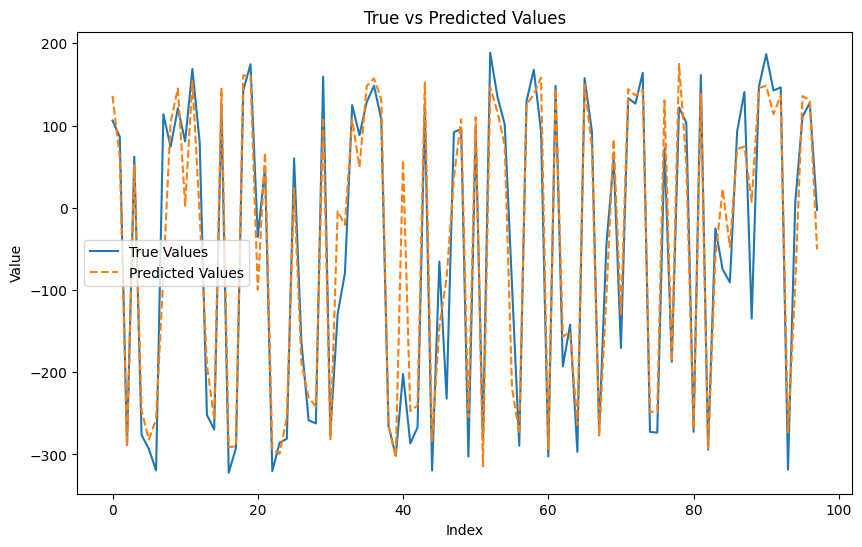

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


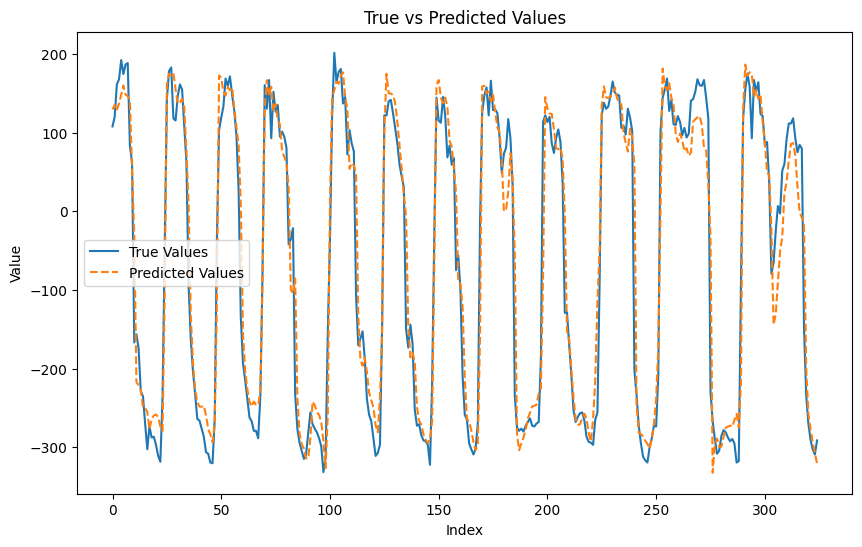

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


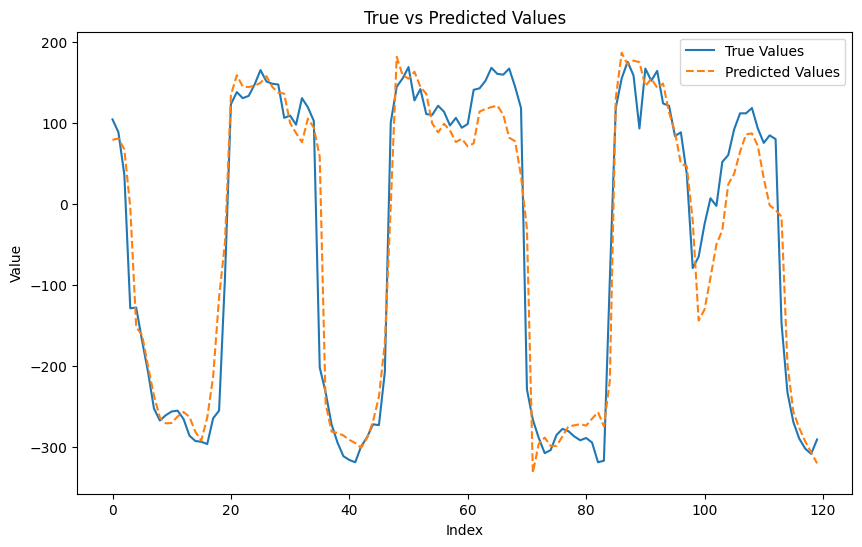

In [18]:
best_model1 = load_model(checkpoint_filepath1, custom_objects={'r_squared': r_squared})
y_test_pred1 = plot_true_vs_predicted(best_model1, x_test, y_test, target_scaler)
y_pred1 = plot_true_vs_predicted(best_model1, X, y, target_scaler)
y_final_pred1 = plot_true_vs_predicted(best_model1, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final1 = target_scaler.inverse_transform(y_final_pred1.reshape(-1, 1))
inverse_scaled_y_Predict1 = target_scaler.inverse_transform(y_pred1.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 747ms/step


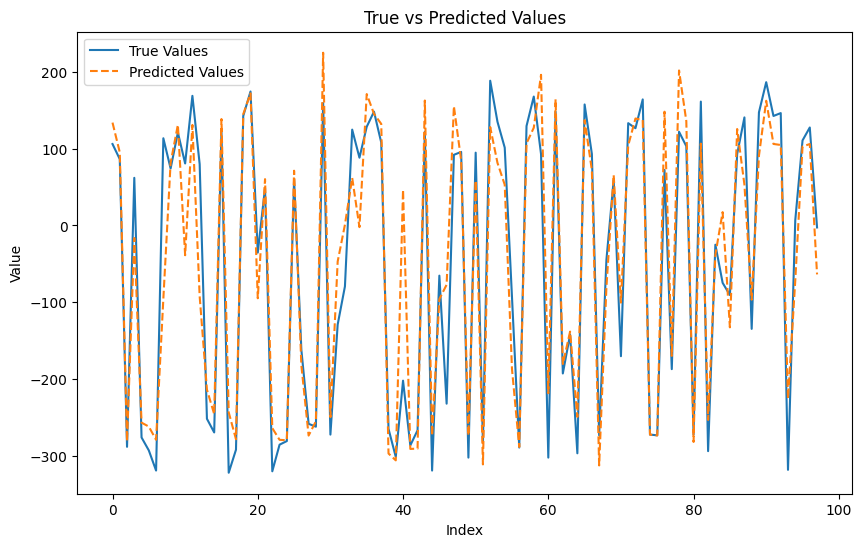

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


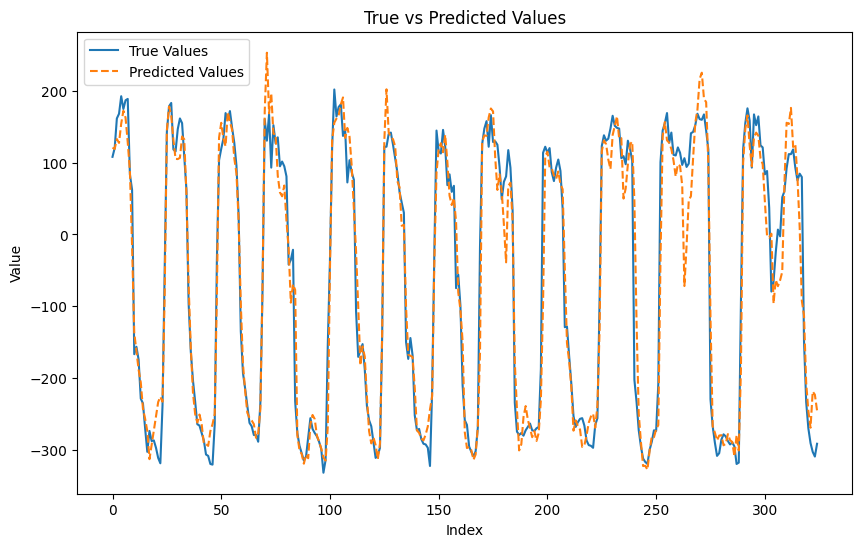

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


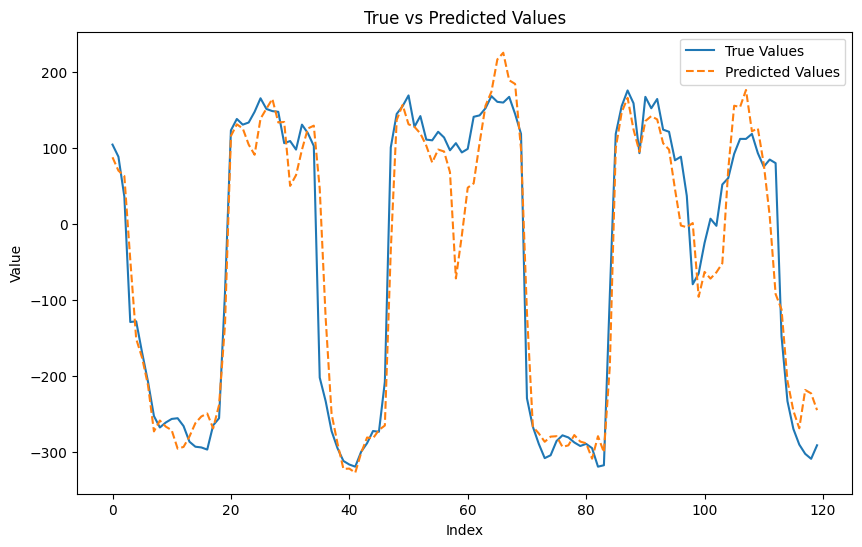

In [19]:
model.save('best_model_transformer.keras')

best_model2 = load_model('best_model_transformer.keras', custom_objects={'r_squared': r_squared})
## best_model2 = load_model(checkpoint_filepath2, custom_objects={'r_squared': r_squared})
y_test_pred2 = plot_true_vs_predicted(best_model2, x_test, y_test, target_scaler)
y_pred2 = plot_true_vs_predicted(best_model2, X, y, target_scaler)
y_final_pred2 = plot_true_vs_predicted(best_model2, x_final, y_final, target_scaler)

inverse_scaled_y_pred_final2 = target_scaler.inverse_transform(y_final_pred2.reshape(-1, 1))
inverse_scaled_y_Predict2 = target_scaler.inverse_transform(y_pred2.reshape(-1, 1))

In [20]:
# 1. Prediksi data training dan testing
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

# Inverse transform data training (aktual & prediksi)
inverse_scaled_y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1))

# Inverse transform data testing (aktual & prediksi)
inverse_scaled_y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


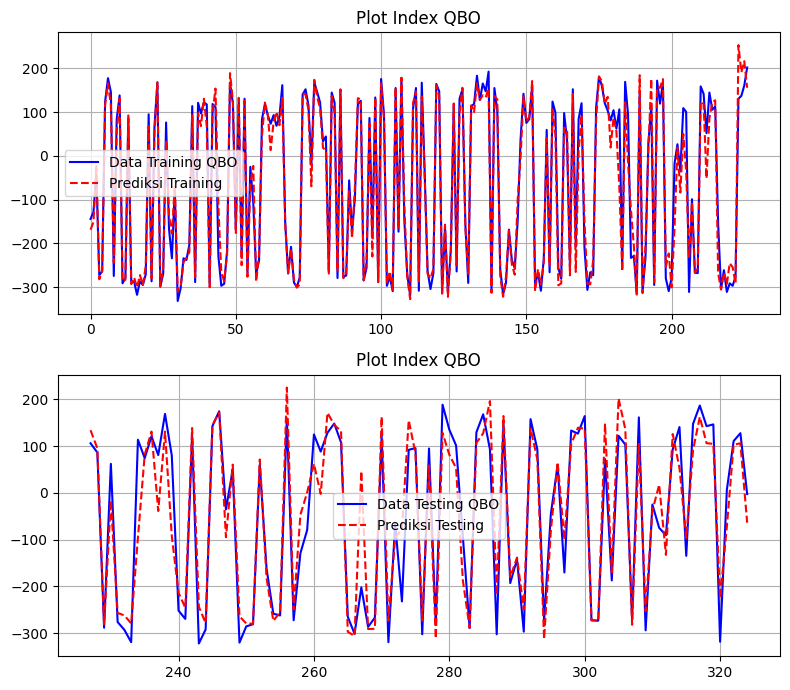

In [21]:
# Asumsikan variabel berikut sudah ada dan sudah inverse_transform:
inverse_scaled_y_train, inverse_scaled_y_train_pred
inverse_scaled_y_test, inverse_scaled_y_test_pred

# Untuk mendapatkan index global pada data test (misal setelah train 0-369, test 370-419)
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(8, 7))

# --------- Subplot 1: Data Training ----------
plt.subplot(2, 1, 1)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Data Training QBO')
plt.plot(train_idx, inverse_scaled_y_train_pred, 'r--', label='Prediksi Training')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

# --------- Subplot 2: Data Testing ----------
plt.subplot(2, 1, 2)
plt.plot(test_idx, inverse_scaled_y_test, 'b-', label='Data Testing QBO')
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Prediksi Testing')
plt.title('Plot Index QBO')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
def r_squared(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [23]:
def calculate_metrics_and_print(original_data, predictions):
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_data, predictions)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # R-squared (R2)
    r2 = r2_score(original_data, predictions)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(original_data, predictions)

    # Log Likelihood
    residuals = original_data - predictions
    log_likelihood = np.sum(norm.logpdf(residuals))

    # Mean Absolute Percentage Error (MAPE)
    ape = np.abs((original_data - predictions) / original_data)
    mape = np.mean(ape) * 100

    # Print the metrics
    print("Metrics for Original Data Model:")
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    print("R-squared: ", r2)
    print("MAE: ", mae)
    print("Log Likelihood: ", log_likelihood)
    print("MAPE: ", mape)

In [24]:
calculate_metrics_and_print(y, y_pred1)

Metrics for Original Data Model:
MSE:  0.06714743977061119
RMSE:  0.259128230362134
R-squared:  0.9329421022725181
MAE:  0.17920478974044
Log Likelihood:  -198700.44959217435
MAPE:  169.74355761749663


In [25]:
calculate_metrics_and_print(y, y_pred2)

Metrics for Original Data Model:
MSE:  0.05646233608386246
RMSE:  0.2376180466291701
R-squared:  0.9436129572251613
MAE:  0.1546585521993401
Log Likelihood:  -198897.20656010197
MAPE:  169.71175315994077


In [26]:
calculate_metrics_and_print(y_test,y_test_pred1)

Metrics for Original Data Model:
MSE:  0.08738501346827376
RMSE:  0.2956095625453848
R-squared:  0.9082437558353131
MAE:  0.20077688217610995
Log Likelihood:  -17463.43386879308
MAPE:  209.35585095039139


In [27]:
calculate_metrics_and_print(y_test,y_test_pred2)

Metrics for Original Data Model:
MSE:  0.10404713167277091
RMSE:  0.3225633762112043
R-squared:  0.8907481541801417
MAE:  0.22973944263210497
Log Likelihood:  -17446.61634476963
MAPE:  207.73931349563028


In [28]:
inverse_scaled_target = target_scaler.inverse_transform(y.reshape(-1, 1))
inverse_scaled_y_final = target_scaler.inverse_transform(y_final.reshape(-1, 1))

In [29]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict1)

Metrics for Original Data Model:
MSE:  2389.618766292778
RMSE:  48.88372700902396
R-squared:  0.9329421030638435
MAE:  33.80642042202858
Log Likelihood:  -388611.704545868
MAPE:  41.48214552356511


In [30]:
calculate_metrics_and_print(inverse_scaled_target, inverse_scaled_y_Predict2)

Metrics for Original Data Model:
MSE:  2009.361204497752
RMSE:  44.82589881416492
R-squared:  0.9436129568199865
MAE:  29.175850748409076
Log Likelihood:  -326819.8507541762
MAPE:  37.725484876931446


In [31]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final1)

Metrics for Original Data Model:
MSE:  2798.5200860488135
RMSE:  52.90104050062544
R-squared:  0.9228741896903883
MAE:  34.75663068785463
Log Likelihood:  -168021.47778691337
MAPE:  56.154777301326064


In [32]:
calculate_metrics_and_print(inverse_scaled_y_final, inverse_scaled_y_pred_final2)

Metrics for Original Data Model:
MSE:  2785.431352477606
RMSE:  52.77718590904223
R-squared:  0.9232349086245272
MAE:  35.280031562815296
Log Likelihood:  -167236.15377264092
MAPE:  58.05361868664295


In [33]:
# --- LSTM ---
# Prediksi di data test (10%)
y_test_pred_lstm = best_model1.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_lstm = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_lstm = target_scaler.inverse_transform(y_test_pred_lstm.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (LSTM)
print("=== Metrics Test Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_test_lstm, inverse_scaled_y_test_pred_lstm)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_lstm = best_model1.predict(x_train)
inverse_scaled_y_train_lstm = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_lstm = target_scaler.inverse_transform(y_train_pred_lstm.reshape(-1, 1))
print("=== Metrics Train Set - LSTM ===")
calculate_metrics_and_print(inverse_scaled_y_train_lstm, inverse_scaled_y_train_pred_lstm)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
=== Metrics Test Set - LSTM ===
Metrics for Original Data Model:
MSE:  3109.826276190641
RMSE:  55.765816376976325
R-squared:  0.9082437549402919
MAE:  37.87592849037041
Log Likelihood:  -152471.54350959545
MAPE:  65.71218869999551
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
=== Metrics Train Set - LSTM ===
Metrics for Original Data Model:
MSE:  2078.6922621465847
RMSE:  45.592677725119245
R-squared:  0.9426848652960885
MAE:  32.04954111023416
Log Likelihood:  -236140.17080067476
MAPE:  31.02160242925024


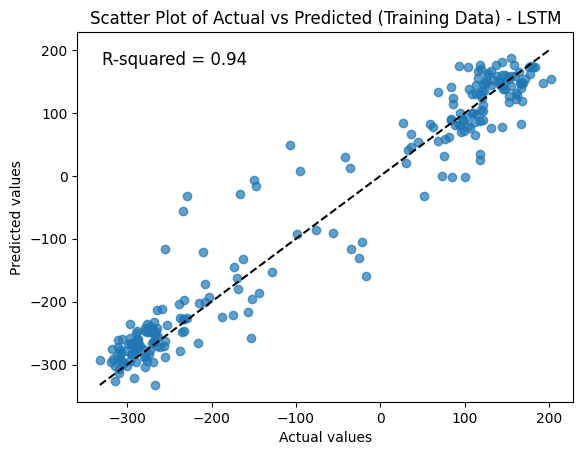

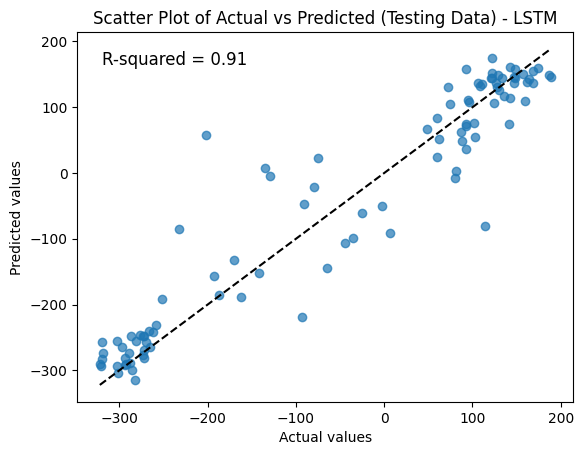

In [34]:
def plot_r2_scatter(y_true, y_pred, title, ax=None):
    r2 = r2_score(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, alpha=0.7)
    # Garis diagonal y=x
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')
    ax.text(0.05, 0.95, f'R-squared = {r2:.2f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top')
    ax.set_title(title)
    ax.set_xlabel("Actual values")
    ax.set_ylabel("Predicted values")

# --- LSTM ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_lstm, 
    inverse_scaled_y_train_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Training Data) - LSTM"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_lstm, 
    inverse_scaled_y_test_pred_lstm, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - LSTM"
)
plt.show()

In [35]:
# --- TRANSFORMER ---
# Prediksi di data test (10%)
y_test_pred_transformer = best_model2.predict(x_test)
# Kembalikan ke skala asli
inverse_scaled_y_test_transformer = target_scaler.inverse_transform(y_test.reshape(-1, 1))
inverse_scaled_y_test_pred_transformer = target_scaler.inverse_transform(y_test_pred_transformer.reshape(-1, 1))
# Hitung & tampilkan metrics untuk data test (Transformer)
print("=== Metrics Test Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_test_transformer, inverse_scaled_y_test_pred_transformer)

# (Jika ingin juga untuk data train, gunakan ini:)
y_train_pred_transformer = best_model2.predict(x_train)
inverse_scaled_y_train_transformer = target_scaler.inverse_transform(y_train.reshape(-1, 1))
inverse_scaled_y_train_pred_transformer = target_scaler.inverse_transform(y_train_pred_transformer.reshape(-1, 1))
print("=== Metrics Train Set - Transformer ===")
calculate_metrics_and_print(inverse_scaled_y_train_transformer, inverse_scaled_y_train_pred_transformer)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
=== Metrics Test Set - Transformer ===
Metrics for Original Data Model:
MSE:  3702.7917175050425
RMSE:  60.850568752519
R-squared:  0.8907481530921303
MAE:  43.33962529367916
Log Likelihood:  -181526.85013400117
MAPE:  70.80752508702436
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
=== Metrics Train Set - Transformer ===
Metrics for Original Data Model:
MSE:  1278.2766591355064
RMSE:  35.75299510720055
R-squared:  0.9647544755703473
MAE:  23.061093136445567
Log Likelihood:  -145292.99985891744
MAPE:  23.443372654903204


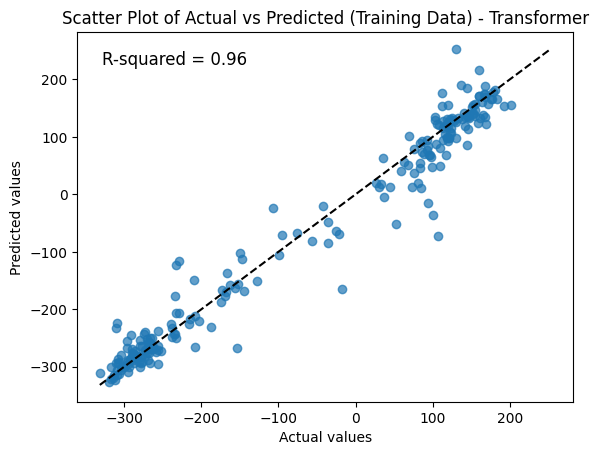

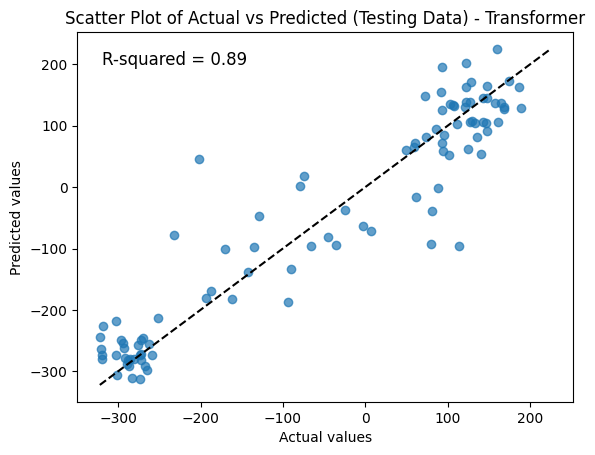

In [36]:
# --- TRANSFORMER ---
# Data Training
plot_r2_scatter(
    inverse_scaled_y_train_transformer, 
    inverse_scaled_y_train_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Training Data) - Transformer"
)
plt.show()

# Data Testing
plot_r2_scatter(
    inverse_scaled_y_test_transformer, 
    inverse_scaled_y_test_pred_transformer, 
    "Scatter Plot of Actual vs Predicted (Testing Data) - Transformer"
)
plt.show()

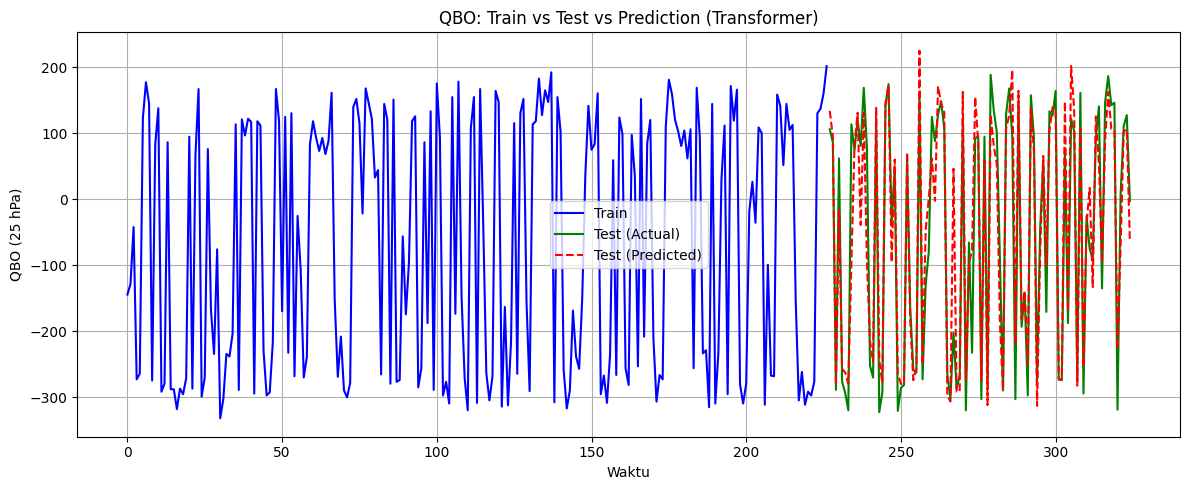

In [37]:
# Misal train_len = jumlah data train
train_len = len(inverse_scaled_y_train)
test_len = len(inverse_scaled_y_test)
train_idx = np.arange(train_len)
test_idx = np.arange(train_len, train_len + test_len)

plt.figure(figsize=(12,5))

# Plot data train (aktual)
plt.plot(train_idx, inverse_scaled_y_train, 'b-', label='Train')

# Plot data test (aktual)
plt.plot(test_idx, inverse_scaled_y_test, 'g-', label='Test (Actual)')

# Plot data test (prediksi)
plt.plot(test_idx, inverse_scaled_y_test_pred, 'r--', label='Test (Predicted)')

plt.title('QBO: Train vs Test vs Prediction (Transformer)')
plt.xlabel('Waktu')
plt.ylabel('QBO (25 hPa)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

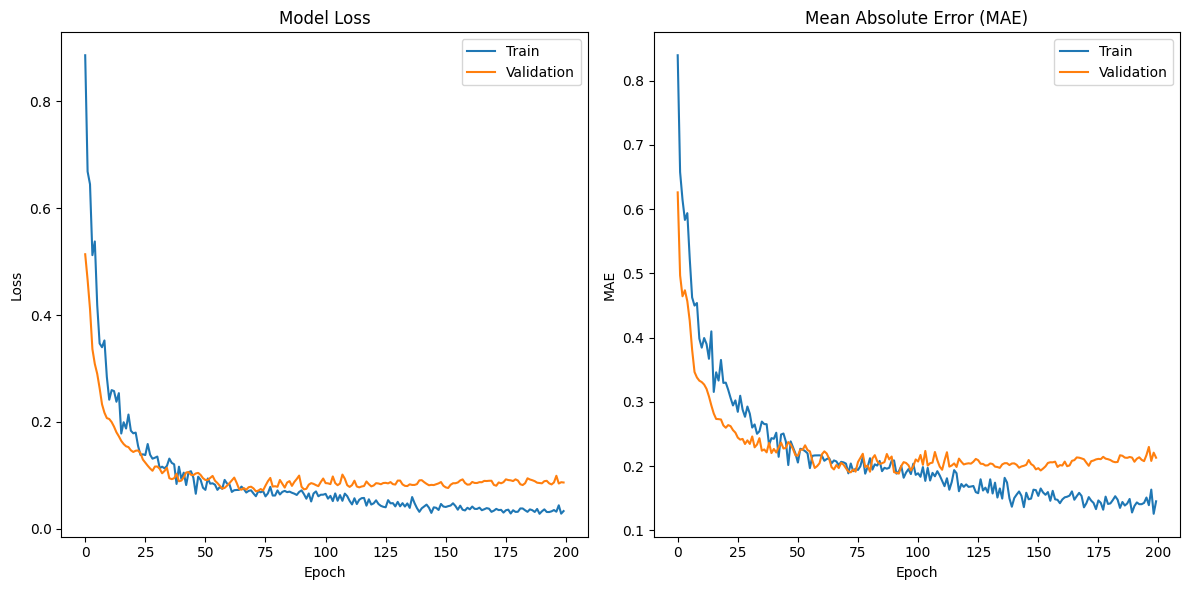

In [38]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation metrics values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

In [39]:
residuals1 = inverse_scaled_target - inverse_scaled_y_Predict1
residuals_final1 = inverse_scaled_y_final - inverse_scaled_y_pred_final1

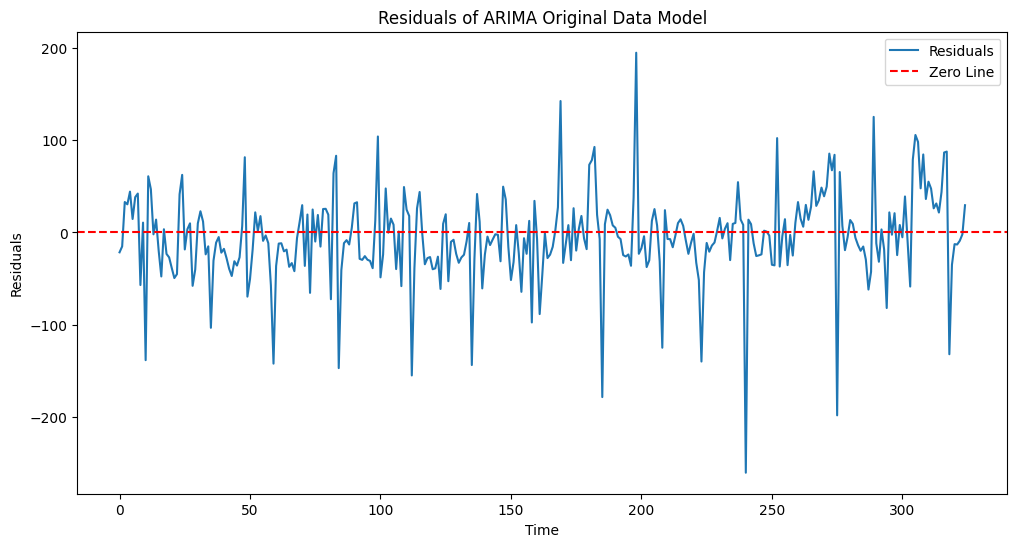

In [40]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

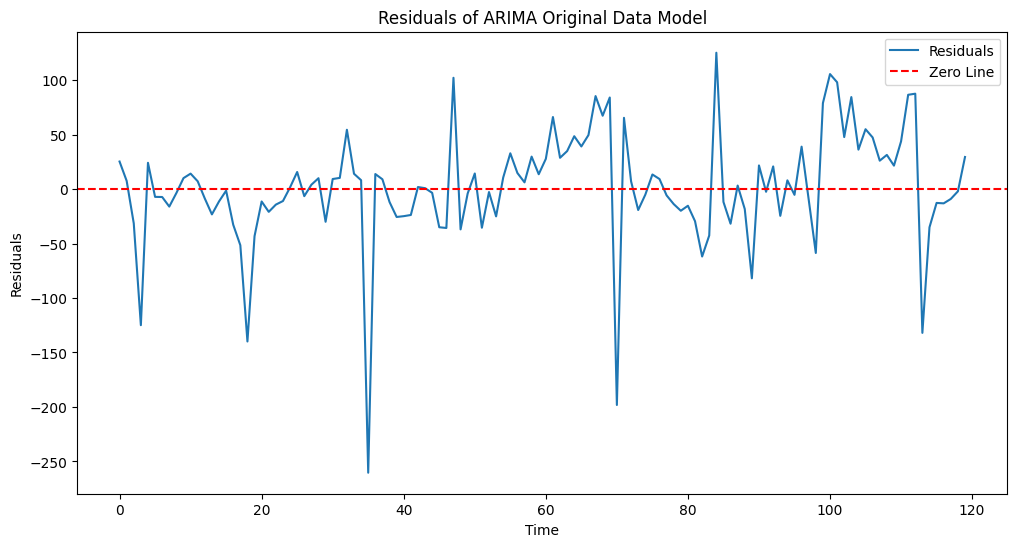

In [41]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final1, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [42]:
residuals2 = inverse_scaled_target - inverse_scaled_y_Predict2
residuals_final2 = inverse_scaled_y_final - inverse_scaled_y_pred_final2

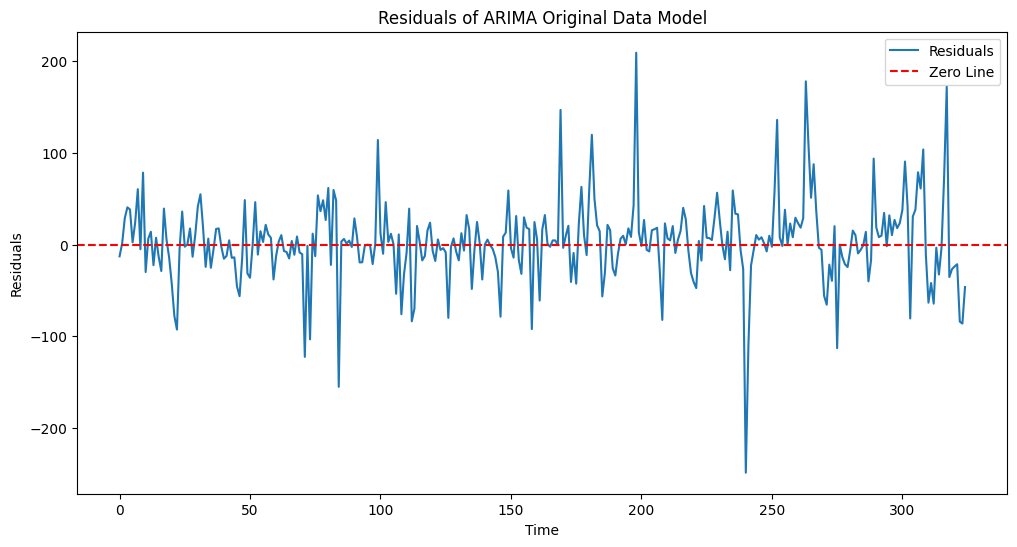

In [43]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

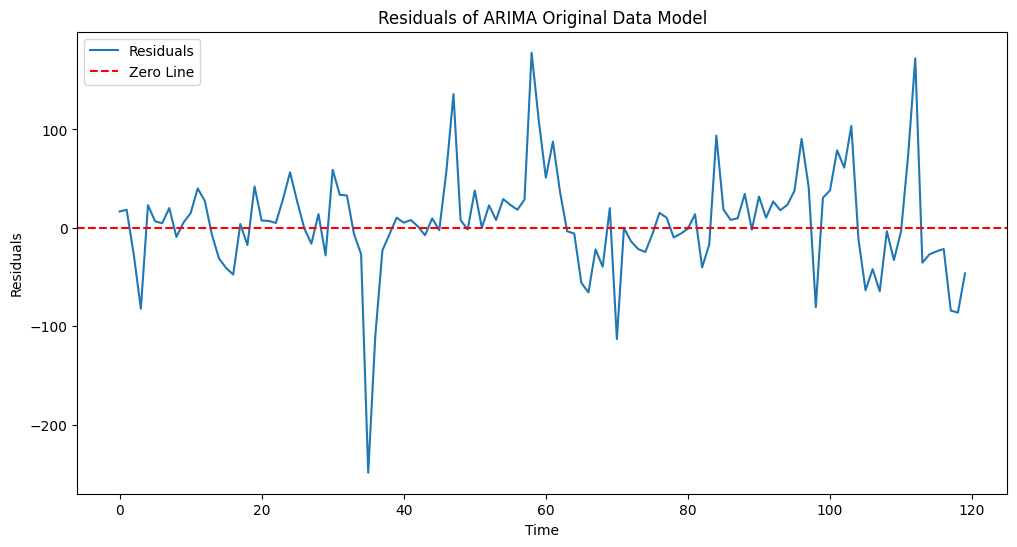

In [44]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_final2, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Residuals of ARIMA Original Data Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

In [45]:
def residual_analysis(residuals):
    # Shapiro-Wilk Test for normality
    stat, p_value = shapiro(residuals)
    print("Shapiro-Wilk Test (Normality):")
    print("Test Statistic:", stat)
    print("P-value:", p_value)
    if p_value > 0.05:
        print("The residuals appear to be normally distributed.")
    else:
        print("The residuals may not be normally distributed.")

    # Anderson-Darling Test for normality
    result = anderson(residuals)
    test_statistic = result.statistic
    critical_values = result.critical_values

    # Plot ACF and PACF on residuals
    plt.figure(figsize=(12, 6))
    acf_res = plot_acf(residuals, title='ACF of Residuals')
    pacf_res = plot_pacf(residuals, title='PACF of Residuals')
    plt.show()

    # Plot histogram of residuals
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9219838123625214
P-value: 5.591444255007565e-12
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

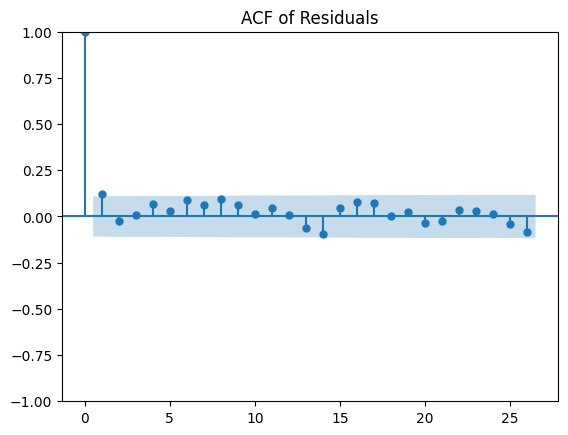

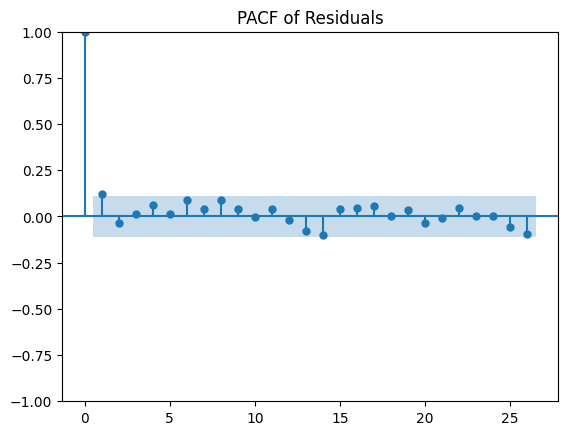

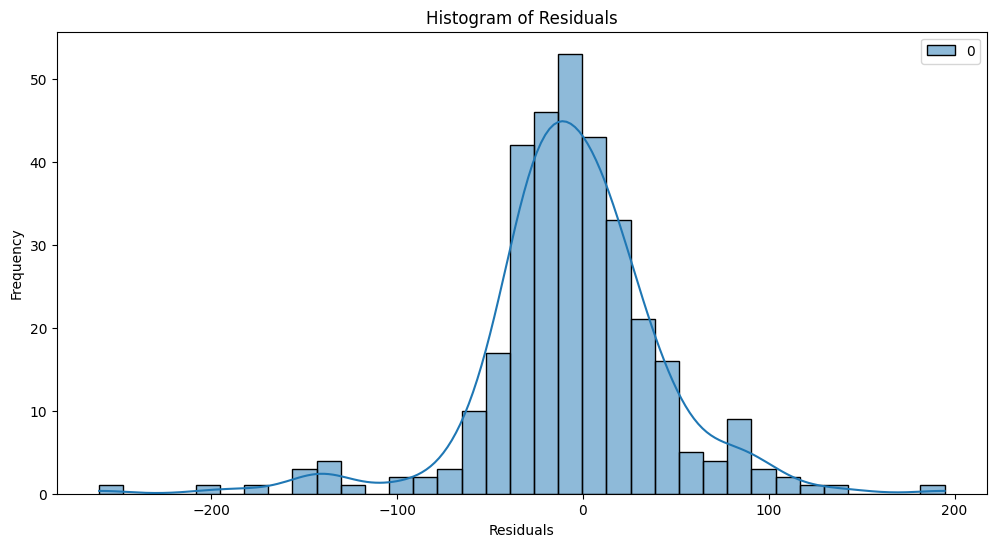

In [46]:
residual_analysis(residuals1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.8779267931830365
P-value: 1.7005427629614548e-08
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

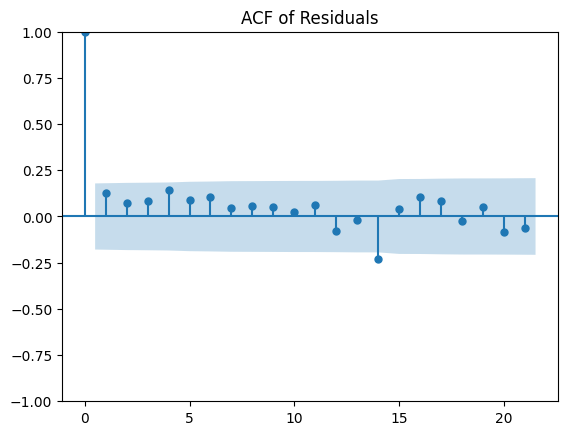

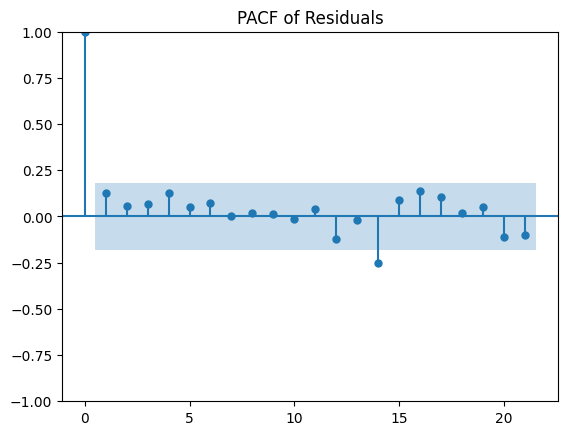

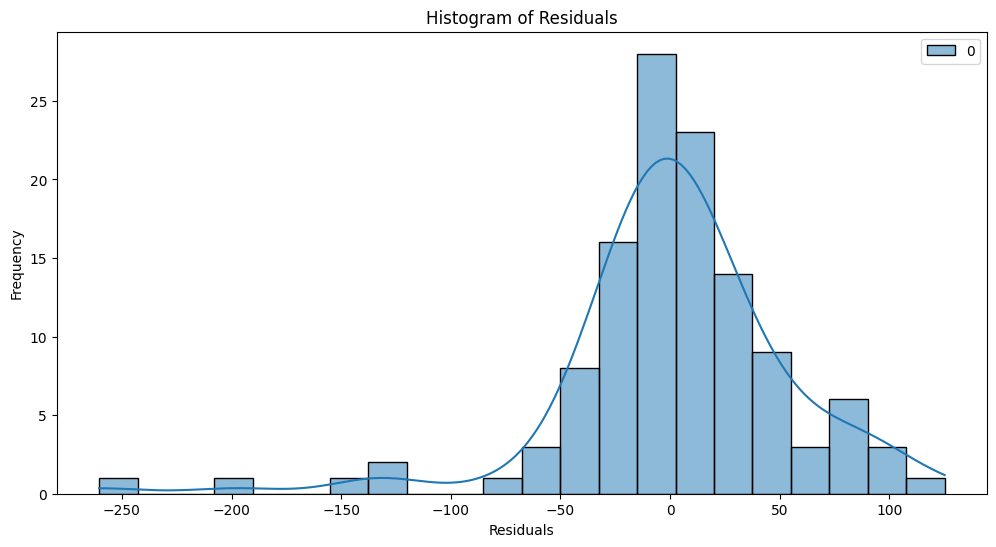

In [47]:
residual_analysis(residuals_final1)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9050223872247757
P-value: 2.0240099316308316e-13
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

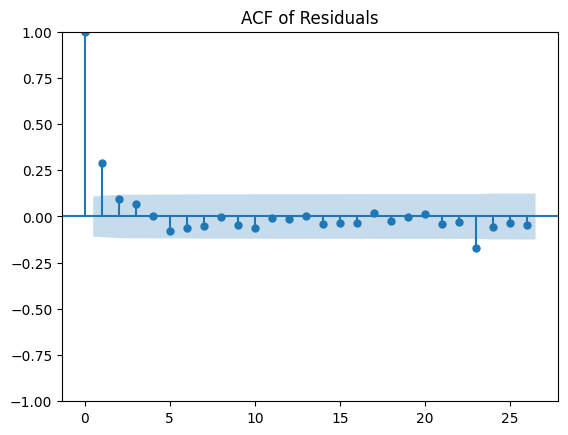

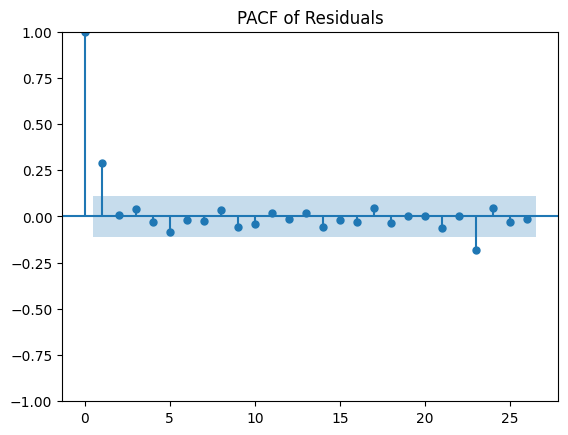

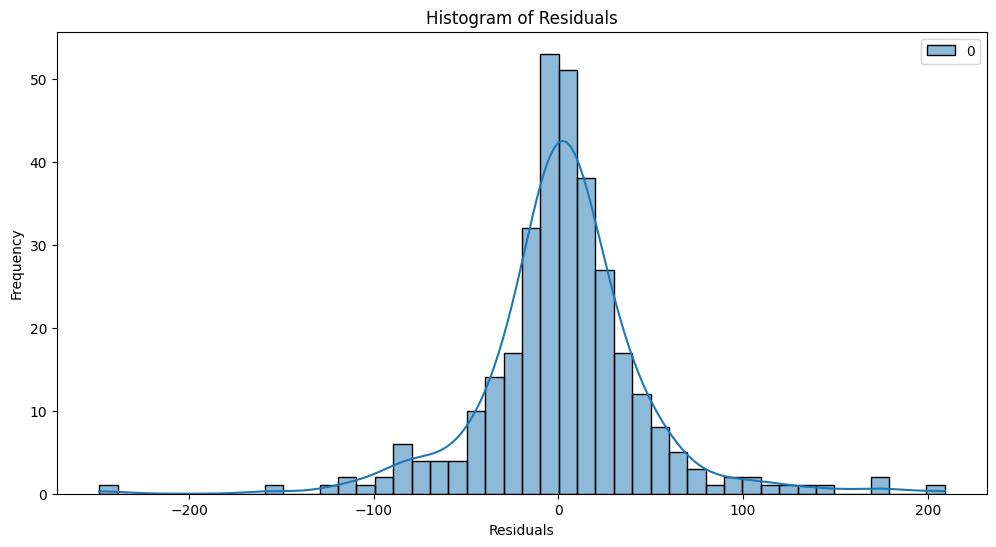

In [48]:
residual_analysis(residuals2)

Shapiro-Wilk Test (Normality):
Test Statistic: 0.9140208418335439
P-value: 1.0999993980978433e-06
The residuals may not be normally distributed.


<Figure size 1200x600 with 0 Axes>

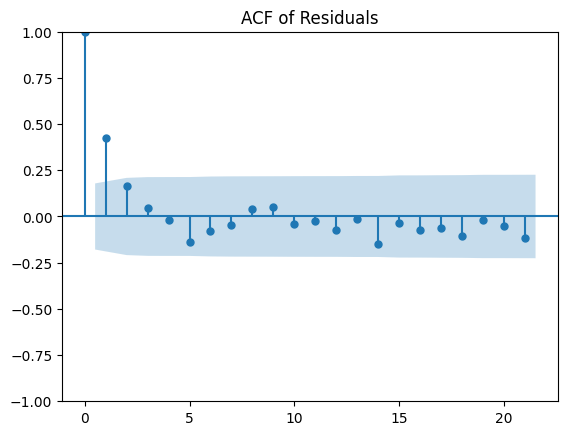

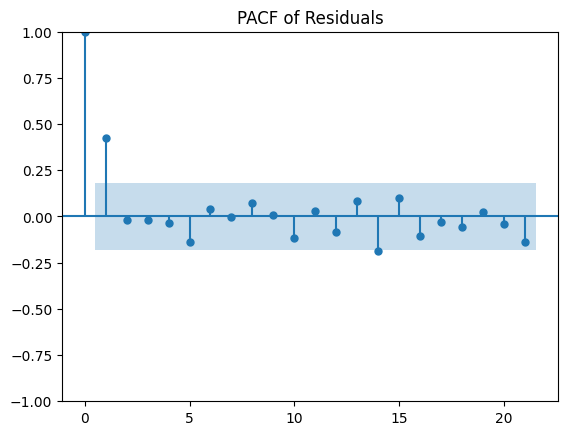

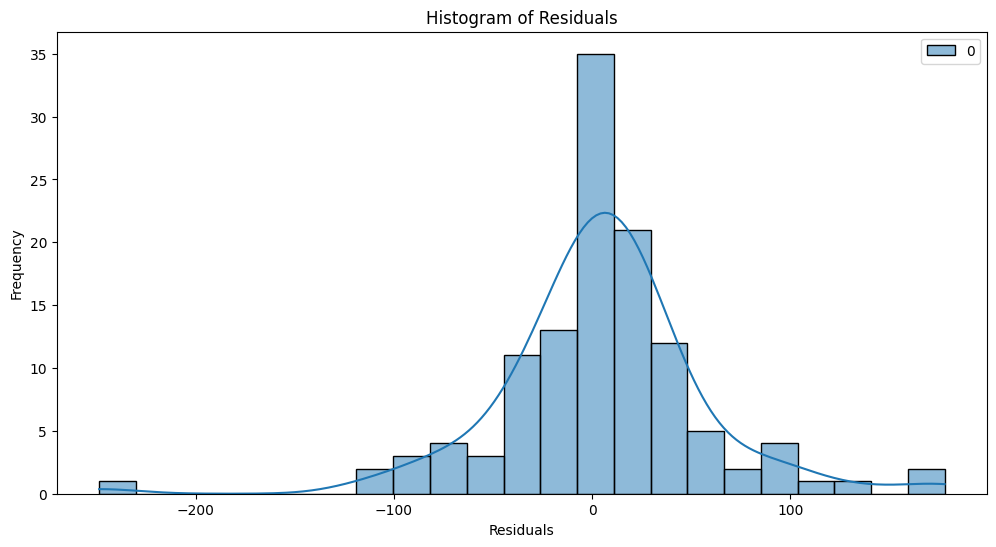

In [49]:
residual_analysis(residuals_final2)

In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dan atur data
data_df = pd.read_excel('QBO Data.xlsx')
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d%m%Y')
data_df.set_index('Date', inplace=True)
data_df = data_df[['25 hPa']]

In [51]:
# Fit ARIMA (bisa ubah order sesuai hasil AIC/BIC terbaik)
model_arima = ARIMA(data_df['25 hPa'], order=(4, 0, 5))  # Contoh order
model_fit = model_arima.fit()

# Prediksi in-sample
arima_pred = model_fit.fittedvalues

# Residual = aktual - prediksi
data_df['residual'] = data_df['25 hPa'] - arima_pred

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

In [52]:
# Gunakan residual sebagai target Transformer
target_col = 'residual'

# Tambahkan fitur seperti sebelumnya (gunakan data_df)
add_lag_features(data_df, lags)
add_rolling_statistics(data_df, window_sizes)
add_interaction_features(data_df, window_sizes)
add_seasonal_features(data_df)
add_rate_of_change(data_df, lags)
add_cumulative_sum(data_df)
add_ewma_std(data_df, window_sizes)
add_additional_statistics(data_df, window_sizes)
add_z_scores(data_df)
add_log_returns(data_df)

# Drop NaN
data_df = data_df.dropna()

# Pisahkan input dan target
X = data_df.drop(columns=['25 hPa', 'residual'])
y = data_df['residual']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tambahkan dimensi time untuk Transformer
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  # shape: (samples, time, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

In [54]:
def build_transformer(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64)(inputs)
    
    attention_output = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_transformer(X_train_scaled.shape[1:])  # input shape = (time, features)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 78)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 64)     │      5,056 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1, 64)     │          0 │ dense_4[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         33 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,937 (93.50 KB)

 Trainable params: 23,937 (93.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# === 1. Load Model dan Scaler ===
best_model = load_model('best_model_lstm.h5')
feature_scaler = ...  # gunakan scaler yang sama dengan training
target_scaler = ...   # gunakan scaler yang sama dengan training

# === 2. Siapkan data terakhir sebagai input forecasting ===
# Ambil data asli yang sudah diproses dan gunakan top_features_index_names yang sama dengan training
n_steps = 28  # time_steps yang digunakan saat training
n_features = 20  # jumlah fitur terpilih, sesuaikan dengan training
n_forecast = 12  # jumlah prediksi ke depan

# Gunakan data_df_drop dan top_features_index_names dari training
recent_data = data_df_drop[top_features_index_names].values[-n_steps:]
recent_data_scaled = feature_scaler.transform(recent_data)
input_seq = recent_data_scaled.reshape(1, n_steps, n_features)

# === 3. Forecasting (Recursive, multi-step) ===
forecast_scaled = []
input_for_pred = input_seq.copy()

for i in range(n_forecast):
    next_pred_scaled = best_model.predict(input_for_pred)
    forecast_scaled.append(next_pred_scaled[0, 0])
    # Buat fitur baru: prediksi + geser window
    next_feat = input_for_pred[0, 1:, :]  # buang langkah terlama
    # Update fitur pertama (target) dengan prediksi; fitur lain tetap (atau bisa diisi rata-rata, dsb)
    new_row = np.copy(input_for_pred[0, -1, :])
    new_row[0] = next_pred_scaled  # update fitur target
    # Tambahkan ke sequence berikutnya
    input_for_pred = np.append(next_feat, new_row.reshape(1, -1), axis=0)
    input_for_pred = input_for_pred.reshape(1, n_steps, n_features)

# === 4. Inverse scaling ke nilai asli ===
forecast_scaled_np = np.array(forecast_scaled).reshape(-1, 1)
forecast_actual = target_scaler.inverse_transform(forecast_scaled_np).flatten()

# === 5. Buat index waktu prediksi ===
last_date = data_df_drop.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=n_forecast+1, freq='MS')[1:]  # +1 lalu skip pertama

# === 6. Buat DataFrame hasil forecast ===
forecast_df = pd.DataFrame({'forecast': forecast_actual}, index=forecast_dates)

# === 7. Plot hasil prediksi ===
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(data_df_drop['25 hPa'], label='Data Aktual')
plt.plot(forecast_df['forecast'], label='Forecast', color='red')
plt.legend()
plt.title('Forecast LSTM')
plt.show()

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 2043.4150 - val_loss: 1320.8114
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1881.8585 - val_loss: 1311.3660
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2056.8438 - val_loss: 1290.1167
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1982.6167 - val_loss: 1259.3618
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2137.4304 - val_loss: 1219.8374
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1664.7008 - val_loss: 1160.5344
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1850.4160 - val_loss: 1068.7017
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1864.5585 - val_loss: 992.9933
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1557.6925 - val_loss: 927.3241
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1569.0557 - val_loss: 857.5305
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1732.1575 - val_loss: 824.4955
E

ValueError: operands could not be broadcast together with shapes (76,) (71,) 